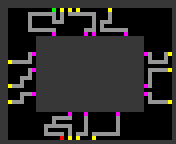


goal in 566 steps



test2: 396 396


In [1]:
from PIL import Image
from IPython import display
import numpy as np
import cv2
import math


def rev(d):
    r={}
    for k in d.keys():
        r[d[k]]=k
    return r
    


def ld(fn):
    #read map 
    m={}
    for y,l in enumerate(open(fn).read().split('\n')):
        #if y in range(40,50):
        #    print(l[:20])
        for x,v in enumerate(l):
            p=(x,y)
            #print(v)
            if v=='.' or v=='#' or v.isalpha():
                m[p]=v
    
    w=max([z[0] for z in m.keys()])
    h=max([z[1] for z in m.keys()])
    
    
    #prune dead ends in map for speedup
    while 1:
        done=1
        for x,y in m.keys():
            if m[(x,y)]=='.':
                nnn=0
                for dx,dy in [(1,0),(0,1),(-1,0),(0,-1)]:
                    ppp=(x+dx,y+dy)
                    if ppp in m and m[ppp] != '#':
                        nnn+=1
                if nnn==1:        
                    m[(x,y)]='#'
                    done=0
                    break
        if done:
            break
    
    #build warp table
    
    
    A=(0,0)
    Z=(1,1)
    wo={}
    wi={}
    for k1 in m.keys():
        x,y=k1
        for dx,dy in [(1,0),(0,1),(-1,0),(0,-1)]:
            k2=(x+dx*1,y+dy*1)
            k3=(x+dx*2,y+dy*2)
            if k2 in m and k3 in m:
                if m[k1]=='.':
                    if m[k2].isalpha() and m[k3].isalpha():
                        lbl=m[k3]+m[k2]
                        if (dx,dy) in [(1,0),(0,1)]:
                            lbl=m[k2]+m[k3]
                        
                        if lbl=="AA":
                            A=k1
                        elif lbl=="ZZ":
                            Z=k1
                        else:
                            mgn=6
                            if x > mgn and x < w-mgn and y > mgn and y < h-mgn:
                                wi[k1]=lbl
                            else:
                                wo[k1]=lbl
                        
    """                  
    print("wo2wi")
    wir=rev(wi)
    for k in wo:
        print(k,wo[k],wir[wo[k]])
    print("wi2wo")
    wor=rev(wo)
    for k in wi:
        print(k,wi[k],wor[wi[k]])
    """
    
    
    return m,wo,wi,A,Z,w,h

def pretty(M):
    m,wo,wi,A,Z,w,h=M
    i=np.ones([h,w,3],dtype=np.uint8)*55
    for p in m.keys():
        x,y=p
        if m[p] == '.':
            i[y,x,:]=150
        if m[p] == '#':
            i[y,x,:]=0
    for x,y in wo:
        i[y,x,:]=[255,255,0]
    for x,y in wi:
        i[y,x,:]=[255,0,255] 
    i[A[1],A[0],:]=[255,0,0] 
    i[Z[1],Z[0],:]=[0,255,0] 
    
    
    
    F=4
    i = cv2.resize(i, fx=F, fy=F, dsize=(0, 0), interpolation=cv2.INTER_NEAREST)
    #display.clear_output(wait=True)
    display.display(Image.fromarray(i))


    
def H(p,Z):
    #return 0
    dx=p[0]-Z[0]
    dy=p[1]-Z[1]
    dd=p[2]-Z[2]
    return abs(dx)+abs(dy)+abs(dd)


def _walk(m,p,pl,cost=1):
    assert(p in m and m[p]=='.')
    assert(pl in m and m[pl]=='.')
    assert(p!=pl)
    #return p,1
    x,y=p
    np=[]
    for dx,dy in [(1,0),(0,1),(-1,0),(0,-1)]:
        p2=(x+dx,y+dy)
        if p2 != pl and p2 in m and m[p2]=='.':
            np.append(p2)
    if len(np)==1:
        p,cost=_walk(m,np[0],p,cost+1)
    return p,cost


WM={}
def walk(m,p,pl):
    pid=(p,pl)
    if pid in WM:
        p,c=WM[pid]
        #print("saving %d steps"%(c-1))
        return p,c
    WM[pid]=_walk(m,p,pl)
    return WM[pid]
    
def p2(fn):
    
    M=ld(fn)
    
    pretty(M)
    
    m,wo,wi,A,Z,w,h=M
    
    wor=rev(wo)
    wir=rev(wi)
    
    A=(A[0],A[1],0)
    Z=(Z[0],Z[1],0)
    
    #pos, cost
    e=[(A,0,H(A,Z))]
    past={}
    
    
    steps = 1
    while len(e):
        p,c,_=e[0]
        e=e[1:]
         
        if p==Z:
            print("\ngoal in %d steps"%(steps))
            return c
        
        if steps%1000==0:
            print("s:%d e:%d p:%d   "%(steps,len(e),len(past.keys())),end='\r')
        
        past[p]=1
        
        np=[]
        x,y,d=p
        
        #regular walk in same layer
        for dx,dy in [(1,0),(0,1),(-1,0),(0,-1)]:
            p2=(x+dx,y+dy)
            if p2 in m and m[p2]=='.':
                if 1:
                    p2,cost=walk(m,p2,(x,y))
                    np.append(((p2[0],p2[1],d),cost))
                else:
                    np.append(((x+dx,y+dy,d),1))
        
        #warp out
        if (x,y) in wo and d>0:
            x2,y2=wir[wo[(x,y)]]
            np.append(((x2,y2,d-1),1))
        
        #warp in
        if (x,y) in wi and d<2000:
            x2,y2=wor[wi[(x,y)]]
            np.append(((x2,y2,d+1),1))
        
        for p2,cost in np:
            x,y,d=p2
            pp2=(x,y)
            if not p2 in past and pp2 in m and m[pp2]=='.':
                e.append((p2,c+cost,H(p2,Z)))
        
        e=sorted(e,key=lambda x: sum(x[-2:]))
        if steps >10000000:
            print("\ncancel")
            break
            
        steps += 1
    return "no cigar",steps
   
    
    
print("\n\n\ntest2:",p2("20test.txt"),396)

     




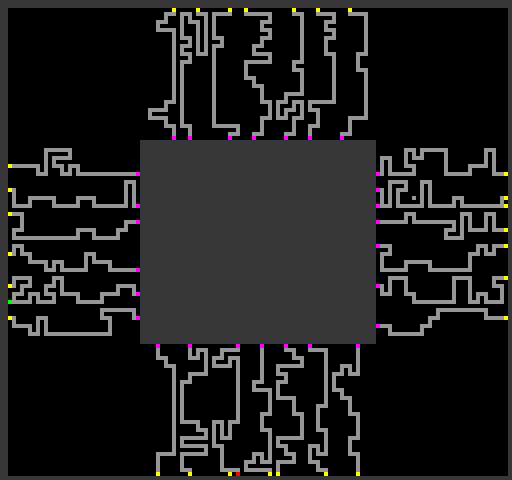

s:5000 e:38 p:4776   
goal in 5329 steps

part2: 6986 6986


In [2]:
print("\npart2:",p2("20.txt"),6986)


